# PREDICTING SEPSIS RISK DURING IN-PATIENT ADMISSIONS
*Client: Royal Perth Hospital*

*Team: Group 7*

# Readme
The following libraries need to be installed in order to run the source code.

In [1]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sweetviz as sv
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.dates import DateFormatter

import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from importlib import reload
import dask.dataframe as dd

np.warnings = warnings

In [2]:
import sys
sys.path.append("..")

# import utility functions
import src.utils as util
reload(util)

import src.load_parquet as load_parquet
reload(load_parquet)

# setup OS agnostic pathnames
ROOT_DIR = Path('..')

# Note: to run main notebook from root directory, use:
# ROOT_DIR = Path('')

import src.DataLoader as DataLoader
reload(DataLoader)

dataLoader = DataLoader.DataLoader(ROOT_DIR)

import src.modelling_pipeline as models
reload(models)

mp = models.ModelPipeline(ROOT_DIR)

In [3]:
# load libraries and modules
import pandas as pd
import numpy as np
import shap

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectFromModel

# model comparison
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# evaluation metrics
from sklearn.metrics import cohen_kappa_score,classification_report 
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, auc, make_scorer
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, balanced_accuracy_score
from sklearn.metrics import PrecisionRecallDisplay

# 1.Dataset Processing

Load the dataset. The following tables are loaded for this project:
- PATIENTS
- ADMISSIONS
- DIAGNOSES_ICD
- LABEVENTS
- MICROBIOLOGYEVENTS
- D_ICD_DIAGNOSES
- D_ITEMS

In [7]:
path_patients = ROOT_DIR / 'data' / "PATIENTS.csv"  
path_admissions = ROOT_DIR / 'data' / "ADMISSIONS.csv"
path_diagnoses_icd = ROOT_DIR / 'data' / "DIAGNOSES_ICD.csv"
path_labevents = ROOT_DIR / 'data' / "LABEVENTS.csv"
path_microbiologyevents = ROOT_DIR / 'data' / "MICROBIOLOGYEVENTS.csv"
path_desc_icd = ROOT_DIR / 'data' / "D_ICD_DIAGNOSES.csv"
path_desc_labitems = ROOT_DIR / 'data' / "D_LABITEMS.csv"
path_desc_items = ROOT_DIR / 'data' /  "D_ITEMS.csv"

In [ ]:
# load transaction dataset
df_patients_full = pd.read_csv(path_patients)
df_admissions_full = pd.read_csv(path_admissions)
df_diagnoses_icd_full = pd.read_csv(path_diagnoses_icd)
df_labevents_full = pd.read_csv(path_labevents)
df_microbiologyevents_full = pd.read_csv(path_microbiologyevents)

# load description tables
df_desc_icd_full = pd.read_csv(path_desc_icd)
df_desc_labitems_full = pd.read_csv(path_desc_labitems)
df_desc_items_full = pd.read_csv(path_desc_items)

## 1.1 Data Cleaning

In [8]:
# Convert the following datetime columns to datetime format
# patients: DOB to date format, we not care about the birth time
df_patients_full['DOB'] = pd.to_datetime(df_patients_full['DOB'], format='%Y-%m-%d %H:%M:%S')
# admissions: ADMITTIME, DISCHTIME, EDREGTIME, EDOUTTIME
df_admissions_full['ADMITTIME'] = pd.to_datetime(df_admissions_full['ADMITTIME'], format='%Y-%m-%d %H:%M:%S')
df_admissions_full['DISCHTIME'] = pd.to_datetime(df_admissions_full['DISCHTIME'], format='%Y-%m-%d %H:%M:%S')
# labevents: CHARTTIME
df_labevents_full['CHARTTIME'] = pd.to_datetime(df_labevents_full['CHARTTIME'], format='%Y-%m-%d %H:%M:%S')
# microbiologyevents: CHARTDATE to date format and CHARTTIME to datetime format
df_microbiologyevents_full['CHARTDATE'] = pd.to_datetime(df_microbiologyevents_full['CHARTDATE'], format='%Y-%m-%d %H:%M:%S')
df_microbiologyevents_full['CHARTTIME'] = pd.to_datetime(df_microbiologyevents_full['CHARTTIME'], format='%Y-%m-%d %H:%M:%S')

The DIAGNOSES_ICD tables has a column ICD9_CODE which is the code for each disease diagnosed for the patient.

The Sepsis has 6 codes: ['77181', '99591', '99592', '67020', '67022', '67024']

We'll introduce a new column, IS_SEPSIS, as a binary classifier (1 for 6 sepsis ICD9 codes, 0 otherwise) for the target variable.

In [9]:
# retrieve all sepsis icd code
sepsis_icd =  df_desc_icd_full[df_desc_icd_full.apply(lambda x:'sepsis' in x['SHORT_TITLE'].lower(),axis=1)]['ICD9_CODE'].values
# add new binary classifier target variable
df_diagnoses_icd_full['IS_SEPSIS'] = df_diagnoses_icd_full.apply(lambda x: 1 if x['ICD9_CODE'] in sepsis_icd else 0, axis=1)

In [10]:
# create function for checking the admission diagnoses to find whether it is diagnosed sepsis
def check_sepsis(subject_id, hadm_id, df_diagnoses_icd):
    admission_diagnoses = df_diagnoses_icd_full[(df_diagnoses_icd_full['SUBJECT_ID'] == subject_id) & (df_diagnoses_icd_full['HADM_ID'] == hadm_id)]
    is_sepsis = 1 if sum(admission_diagnoses['IS_SEPSIS']) > 0 else 0
    return is_sepsis

In [11]:
# create demographic df and save to csv file for future load
try:
    pathname_demographic = ROOT_DIR / 'data' / 'demographic.csv'
    df_demographic_full = pd.read_csv(pathname_demographic)
except:
    # merge the patients and admission tables to a demographic dataframe
    df_demographic_full = pd.merge(df_admissions_full, df_patients_full[['SUBJECT_ID', 'GENDER', 'DOB', 'EXPIRE_FLAG']], on='SUBJECT_ID')
    # create an age column to each case
    df_demographic_full['AGE'] = (((df_demographic_full['ADMITTIME'].dt.date - df_demographic_full['DOB'].dt.date) // 365) / pd.Timedelta(days=1)).astype('int16')
    # add column IS_SEPSIS to demographic data indicating which case is diagnosed with sepsis
    df_demographic_full['IS_SEPSIS'] = df_demographic_full.apply(lambda x: check_sepsis(x['SUBJECT_ID'], x['HADM_ID'], df_diagnoses_icd_full), axis=1)
    util.save_csv(df_demographic_full, ROOT_DIR / 'data' / 'demographic_full.csv')

# convert admittime and dischtime to datetime
df_demographic_full['ADMITTIME'] = pd.to_datetime(df_demographic_full['ADMITTIME'], format='%Y-%m-%d %H:%M:%S')
df_demographic_full['DISCHTIME'] = pd.to_datetime(df_demographic_full['DISCHTIME'], format='%Y-%m-%d %H:%M:%S')

In [12]:
count_over100 = len(df_demographic_full[df_demographic_full.AGE>100])
p_over100 = len(df_demographic_full[df_demographic_full.AGE>100])/len(df_demographic_full)*100
median_age = int(df_demographic_full['AGE'].median())
print('The number of admissions aged over 100 years old is: {} admissions ({:.2f}% over all admissions)'.format(count_over100, p_over100))
print('The median age of patients: {}'.format(median_age))

The number of admissions aged over 100 years old is: 2616 admissions (4.44% over all admissions)
The median age of patients: 61


Load unpivoted labevents dataframe:

In [ ]:
output_dir = ROOT_DIR / 'data' / 'labevents_transform_parquet'
df_labevents_processed = load_parquet.load_labevents_dask(output_dir)

In [14]:
df_labevents_full.head(10)

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG
0,281,3,NaN,50820,2101-10-12 16:07:00,7.39,7.39,units,NaN
1,282,3,NaN,50800,2101-10-12 18:17:00,ART,NaN,NaN,NaN
2,283,3,NaN,50802,2101-10-12 18:17:00,-1,-1.00,mEq/L,NaN
3,284,3,NaN,50804,2101-10-12 18:17:00,22,22.00,mEq/L,NaN
4,285,3,NaN,50808,2101-10-12 18:17:00,0.93,0.93,mmol/L,abnormal
5,286,3,NaN,50812,2101-10-12 18:17:00,NOT INTUBATED,NaN,NaN,NaN
6,287,3,NaN,50813,2101-10-12 18:17:00,1.8,1.80,mmol/L,NaN
7,288,3,NaN,50818,2101-10-12 18:17:00,33,33.00,mm Hg,NaN
8,289,3,NaN,50820,2101-10-12 18:17:00,7.42,7.42,units,NaN
9,290,3,NaN,50821,2101-10-12 18:17:00,80,80.00,mm Hg,NaN


In [ ]:
# Read LABEVENTS.csv and filter rows where HADM_ID is missing 
#HZ

# Read ADMISSIONS.csv
df_empty_hadm_labevents = df_labevents_full[df_labevents_full['HADM_ID'].isnull()]
df_filled_hadm_labevents = df_labevents_full[pd.to_numeric(df_labevents_full["HADM_ID"], errors='coerce').notnull()]

df_admissions_full.sort_values(by=["SUBJECT_ID", "ADMITTIME"], inplace=True)
df_empty_hadm_labevents.sort_values(by=["SUBJECT_ID", "CHARTTIME"], inplace=True)

# Sorting both DataFrames by the keys used for merging

df_admissions_full['ADMITTIME'] = pd.to_datetime(df_admissions_full['ADMITTIME'])
df_admissions_full['DISCHTIME'] = pd.to_datetime(df_admissions_full['DISCHTIME'])
df_empty_hadm_labevents['CHARTTIME'] = pd.to_datetime(df_empty_hadm_labevents['CHARTTIME']) 

# Merge and fill missing HADM_ID using inner join
merged_data = df_empty_hadm_labevents.merge(df_admissions_full, on='SUBJECT_ID', how='inner')
mask = (merged_data['CHARTTIME'] >= merged_data['ADMITTIME']) & (merged_data['CHARTTIME'] <= merged_data['DISCHTIME'])
#Main Task
#if charttime falls between admission time and discharge time then replace labevents hadm_id with admissions table

#to show all the rows
merged_data.loc[mask, 'HADM_ID_x'] = merged_data.loc[mask, 'HADM_ID_y']

# Rename the column back to 'HADM_ID'
merged_data.rename(columns={'HADM_ID_x': 'HADM_ID'}, inplace=True)

# Drop unnecessary columns
merged_data.sort_values(by=["ROW_ID_x"], inplace=True)
merged_data.drop(['HADM_ID_y', 'ROW_ID_y'], axis=1, inplace=True)
merged_data.rename(columns={'SUBJECT_ID_y': 'ADMISSION_SUBJECT_ID'}, inplace=True)

filtered_data_hasHADM = merged_data[merged_data['HADM_ID'].notna()].drop_duplicates(subset=['ROW_ID_x']) #NEED TO CHECK IF unnecessary rows are present since we used merge with adissions and lab events before
filtered_data_noHADM = merged_data[merged_data['HADM_ID'].isnull()].drop_duplicates(subset=['ROW_ID_x'])
filtered_data_hasHADM.rename(columns={'ROW_ID_x': 'ROW_ID'}, inplace=True)
filtered_data_noHADM.rename(columns={'ROW_ID_x': 'ROW_ID'}, inplace=True)

row_ids_in_hasHADM = set(filtered_data_hasHADM['ROW_ID'])
filtered_data_noHADM = filtered_data_noHADM[~filtered_data_noHADM['ROW_ID'].isin(row_ids_in_hasHADM)] #Had to refilter filtered_data_noHADM since there were unnecessary rows

columns_to_remove = ['ADMITTIME','DISCHTIME','DEATHTIME', 'ADMISSION_TYPE',  'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE',    'LANGUAGE', 'RELIGION', 'MARITAL_STATUS',   'ETHNICITY', 'EDREGTIME'    ,'EDOUTTIME'    ,'DIAGNOSIS'    ,'HOSPITAL_EXPIRE_FLAG' ,'HAS_CHARTEVENTS_DATA']

# Drop the specified columns
filtered_data_noHADM = filtered_data_noHADM.drop(columns=columns_to_remove)
filtered_data_hasHADM = filtered_data_hasHADM.drop(columns=columns_to_remove)

# filtered_data_hasHADM.to_csv('filtered_data_hasHADM.csv', index=False)
# filtered_data_noHADM.to_csv('filtered_data_noHADM.csv', index=False)

#Uncomment these if you want to export to CSV
# filtered_data_hasHADM.to_csv('filtered_data_hasHADM.csv', index=False)
# filtered_data_noHADM.to_csv('filtered_data_noHADM.csv', index=False)

In [156]:
# FINAL these three together is the total lab_events len(df_filled_hadm_labevents) + len(filtered_data_hasHADM) + len(filtered_data_noHADM)

combined_df_hasHADM = pd.concat([df_filled_hadm_labevents, filtered_data_hasHADM], ignore_index=True)
combined_df_hasHADM['HADM_ID'] = combined_df_hasHADM['HADM_ID'].astype(int)

In [158]:
df_labevents_clean1 = combined_df_hasHADM
# Merge LABEVENTS with ADMISSIONS on SUBJECT_ID and HADM_ID
combined_df = df_labevents_clean1.merge(df_admissions_full[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME']], 
                               on=['SUBJECT_ID', 'HADM_ID'], 
                               how='left')

# Match to our ground truth IS_SEPSIS
combined_df = combined_df.merge(df_demographic_full[['SUBJECT_ID', 'HADM_ID','IS_SEPSIS']], 
                               on=['SUBJECT_ID', 'HADM_ID'], 
                               how='left')
combined_df.head(10)

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,ADMITTIME,DISCHTIME,IS_SEPSIS
0,441,3,145834,50868,2101-10-20 16:40:00,17,17.0,mEq/L,NaN,2101-10-20 19:08:00,2101-10-31 13:58:00,0
1,442,3,145834,50882,2101-10-20 16:40:00,25,25.0,mEq/L,NaN,2101-10-20 19:08:00,2101-10-31 13:58:00,0
2,443,3,145834,50893,2101-10-20 16:40:00,8.2,8.2,mg/dL,abnormal,2101-10-20 19:08:00,2101-10-31 13:58:00,0
3,444,3,145834,50902,2101-10-20 16:40:00,99,99.0,mEq/L,abnormal,2101-10-20 19:08:00,2101-10-31 13:58:00,0
4,445,3,145834,50910,2101-10-20 16:40:00,48,48.0,IU/L,NaN,2101-10-20 19:08:00,2101-10-31 13:58:00,0
5,446,3,145834,50911,2101-10-20 16:40:00,NotDone,NaN,ng/mL,NaN,2101-10-20 19:08:00,2101-10-31 13:58:00,0
6,447,3,145834,50912,2101-10-20 16:40:00,3.2,3.2,mg/dL,abnormal,2101-10-20 19:08:00,2101-10-31 13:58:00,0
7,448,3,145834,50931,2101-10-20 16:40:00,91,91.0,mg/dL,NaN,2101-10-20 19:08:00,2101-10-31 13:58:00,0
8,449,3,145834,50960,2101-10-20 16:40:00,2.4,2.4,mg/dL,NaN,2101-10-20 19:08:00,2101-10-31 13:58:00,0
9,450,3,145834,50970,2101-10-20 16:40:00,4.8,4.8,mg/dL,abnormal,2101-10-20 19:08:00,2101-10-31 13:58:00,0


## 2.1 Data Exploration

### 2.1.1 Statistics table

In [96]:
# Sepsis vs Non-sepsis (n)
total_counts = len(df_demographic_full)
label_counts = df_demographic_full["IS_SEPSIS"].value_counts()
label_portion = [round(label_counts[0]/total_counts*100, 2), 
                 round(label_counts[1]/total_counts*100, 2)]
label_dict = {0:"No_sepsis", 1: "Sepsis"}

In [172]:
total_counts

58976

In [130]:
# Age (years, median)
age_crosstab = pd.crosstab(df_demographic_full["IS_SEPSIS"], df_demographic_full["AGE"])
age_crosstab

AGE,0,14,15,16,17,18,19,20,21,22,...,302,303,304,305,306,307,308,309,310,311
IS_SEPSIS,,,,,,,,,,,,,,,,,,,,,
0,7880,1,8,22,69,127,150,187,205,204,...,52,42,32,16,20,18,10,5,4,1
1,230,0,0,0,0,6,3,9,7,10,...,25,6,10,6,6,3,2,1,1,0


In [131]:
# For Non-Sepsis group
non_sepsis_ages = []
for age, count in enumerate(age_crosstab.loc[0]):
    non_sepsis_ages.extend([age] * count)
non_sepsis_median = np.median(non_sepsis_ages)

# For Sepsis group
sepsis_ages = []
for age, count in enumerate(age_crosstab.loc[1]):
    sepsis_ages.extend([age] * count)
sepsis_median = np.median(sepsis_ages)

print(f"Median Age for Non-Sepsis: {non_sepsis_median}")
print(f"Median Age for Sepsis: {sepsis_median}")

Median Age for Non-Sepsis: 48.0
Median Age for Sepsis: 54.0


In [134]:
# Create an age category column
df_demographic_full['Age_Category'] = np.where(df_demographic_full['AGE'] < 18, '<18', '18+')

# Group by IS_SEPSIS and Age_Category, then calculate the median age for each group
median_ages = df_demographic_full.groupby(['IS_SEPSIS', 'Age_Category'])['AGE'].median().reset_index()

median_ages

,IS_SEPSIS,Age_Category,AGE
0,0,18+,65.0
1,0,<18,0.0
2,1,18+,68.0
3,1,<18,0.0


In [146]:
# Extracting median age values
median_age_non_sepsis_18plus = round(median_ages[(median_ages['IS_SEPSIS'] == 0) & (median_ages['Age_Category'] == '18+')]['AGE'].values[0],0)
median_age_non_sepsis_less18 = round(median_ages[(median_ages['IS_SEPSIS'] == 0) & (median_ages['Age_Category'] == '<18')]['AGE'].values[0],0)
median_age_sepsis_18plus = round(median_ages[(median_ages['IS_SEPSIS'] == 1) & (median_ages['Age_Category'] == '18+')]['AGE'].values[0],0)
median_age_sepsis_less18 = round(median_ages[(median_ages['IS_SEPSIS'] == 1) & (median_ages['Age_Category'] == '<18')]['AGE'].values[0],0)

In [177]:
# p-value of Age (Mann-Whitney U test because the data isn't normally distributed):
from scipy.stats import ttest_ind, chi2_contingency, mannwhitneyu

u_stat, p_value_age = mannwhitneyu(sepsis_ages, non_sepsis_ages)
p_value_age

2.6428965824693947e-121

In [108]:
# Gender (n, %)
gender_counts = df_demographic_full["GENDER"].value_counts()
gender_portion = [round(gender_counts[0]/total_counts*100, 2), 
                 round(gender_counts[1]/total_counts*100, 2)]
gender_dict = {"M":"Male", "F": "Female"}
gender_long_labels = df_demographic_full['GENDER'].map(gender_dict)

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


In [110]:
gender_crosstab = pd.crosstab(df_demographic_full["IS_SEPSIS"], df_demographic_full["GENDER"])
gender_crosstab_percentage = round(gender_crosstab.div(gender_crosstab.sum(axis=1), axis=0) * 100,2)
gender_crosstab

GENDER,F,M
IS_SEPSIS,,
0,23623,29947
1,2403,3003


In [183]:
# p-value of Gender (using chi-squared test):

gender_contingency_table = [[2403, 3003],
                           [23623, 29937]]
chi2, p_value_gender, _, _ = chi2_contingency(gender_contingency_table)
p_value_gender = round(p_value_gender, 2)
p_value_gender

0.64

In [100]:
# Mortality rate (IS_SEPSIS and EXPIRE_FLAG)
mortality_crosstab = pd.crosstab(df_demographic_full["IS_SEPSIS"], df_demographic_full["EXPIRE_FLAG"])
mortality_crosstab_percentage = round(mortality_crosstab.div(mortality_crosstab.sum(axis=1), axis=0) * 100,2)
mortality_crosstab

EXPIRE_FLAG,0,1
IS_SEPSIS,,
0,34276,19294
1,2114,3292


In [ ]:
# p-value of Mortality rate (using chi-squared test):

gender_contingency_table = [[2403, 3003],
                           [23623, 29937]]
chi2, p_value_gender, _, _ = chi2_contingency(gender_contingency_table)
p_value_gender = round(p_value_gender, 2)
p_value_gender

In [191]:
# First blood test since admission (hours, mean) - We have excluded the rows without HADM_ID in the labevent table

# Merge the two dataframes on ITEMID
first_blood_df = combined_df.merge(df_desc_labitems_full[['ITEMID', 'FLUID']], on='ITEMID', how='left')

# Filter all the blood tests
first_blood_df = first_blood_df[first_blood_df['FLUID'] == 'Blood']

# Sort by HADM_ID and CHARTTIME
first_blood_df = first_blood_df.sort_values(by=['HADM_ID', 'CHARTTIME'])

# Take the first entry for each HADM_ID
first_blood_df = first_blood_df.groupby('HADM_ID').first().reset_index()

# Calculate the time of the first blood test
def calculate_time(row):
    if row['CHARTTIME'] < row['ADMITTIME']:
        return 0
    else:
        return (row['CHARTTIME'] - row['ADMITTIME']).total_seconds() / 3600  # Convert timedelta to hours

first_blood_df['Time_First_Blood_Test'] = first_blood_df.apply(calculate_time, axis=1)


In [212]:
# Separate the data into sepsis and non-sepsis groups based on Time_First_Blood_Test
first_blood_sepsis = first_blood_df[first_blood_df['IS_SEPSIS'] == 1]['Time_First_Blood_Test']
first_blood_non_sepsis = first_blood_df[first_blood_df['IS_SEPSIS'] == 0]['Time_First_Blood_Test']

In [192]:
mean_times = first_blood_df.groupby('IS_SEPSIS')['Time_First_Blood_Test'].mean()

mean_time_sepsis = round(mean_times[1],2)
mean_time_non_sepsis = round(mean_times[0],2)

print(f"Mean Time for First Blood Test for Sepsis: {mean_time_sepsis:.2f} hours")
print(f"Mean Time for First Blood Test for Non-Sepsis: {mean_time_non_sepsis:.2f} hours")

Mean Time for First Blood Test for Sepsis: 0.84 hours
Mean Time for First Blood Test for Non-Sepsis: 2.41 hours


In [208]:
median_times = first_blood_df.groupby('IS_SEPSIS')['Time_First_Blood_Test'].median()

median_time_sepsis = round(median_times[1],2)
median_time_non_sepsis = round(median_times[0],2)

print(f"Median Time for First Blood Test for Sepsis: {median_time_sepsis:.2f} hours")
print(f"Median Time for First Blood Test for Non-Sepsis: {median_time_non_sepsis:.2f} hours")

Median Time for First Blood Test for Sepsis: 0.00 hours
Median Time for First Blood Test for Non-Sepsis: 0.00 hours


In [196]:
# Admission length of stay (days, mean)
first_blood_df['LENGTH_OF_STAY'] = (first_blood_df['DISCHTIME'] - first_blood_df['ADMITTIME']).dt.total_seconds() / (3600 * 24)  # Convert timedelta to days

mean_stay = first_blood_df.groupby('IS_SEPSIS')['LENGTH_OF_STAY'].mean()

mean_stay_sepsis = round(mean_stay[1],2)
mean_stay_non_sepsis = round(mean_stay[0],2)

print(f"Mean Days of Stay for Sepsis: {mean_stay_sepsis:.2f} days")
print(f"Mean Days of Stay for Non-Sepsis: {mean_stay_non_sepsis:.2f} days")

Mean Days of Stay for Sepsis: 16.74 days
Mean Days of Stay for Non-Sepsis: 9.53 days


In [210]:
# Admission length of stay (days, median)
first_blood_df['LENGTH_OF_STAY'] = (first_blood_df['DISCHTIME'] - first_blood_df['ADMITTIME']).dt.total_seconds() / (3600 * 24)  # Convert timedelta to days

median_stay = first_blood_df.groupby('IS_SEPSIS')['LENGTH_OF_STAY'].median()

median_stay_sepsis = round(median_stay[1],2)
median_stay_non_sepsis = round(median_stay[0],2)

print(f"Median Days of Stay for Sepsis: {median_stay_sepsis:.2f} days")
print(f"Median Days of Stay for Non-Sepsis: {median_stay_non_sepsis:.2f} days")

Median Days of Stay for Sepsis: 10.07 days
Median Days of Stay for Non-Sepsis: 6.23 days


In [198]:
# p-value of length of stay (Mann-Whitney U test because the data isn't normally distributed):

# Separate the data into sepsis and non-sepsis groups based on LENGTH_OF_STAY
stay_sepsis = first_blood_df[first_blood_df['IS_SEPSIS'] == 1]['LENGTH_OF_STAY']
stay_non_sepsis = first_blood_df[first_blood_df['IS_SEPSIS'] == 0]['LENGTH_OF_STAY']

u_stat_stay, p_value_stay = mannwhitneyu(stay_sepsis, stay_non_sepsis)
p_value_stay

3.0306802540614646e-280

In [203]:
import statsmodels.api as sm

# Prepare the data
X = first_blood_df['LENGTH_OF_STAY']
X = sm.add_constant(X)  # Adds a constant term to the predictor
y = first_blood_df['IS_SEPSIS']

# Fit logistic regression model
model = sm.Logit(y, X)
result = model.fit()

# Display results
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.299627
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              IS_SEPSIS   No. Observations:                58167
Model:                          Logit   Df Residuals:                    58165
Method:                           MLE   Df Model:                            1
Date:                Tue, 10 Oct 2023   Pseudo R-squ.:                 0.03086
Time:                        22:18:05   Log-Likelihood:                -17428.
converged:                       True   LL-Null:                       -17983.
Covariance Type:            nonrobust   LLR p-value:                2.191e-243
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.6279      0.019   -141.478      0.000      -2.664      -2.591
LENGTH_OF_STAY   

In [206]:
# Statistic table

demographic_stat_data = {
  'Variable': ['n', 
               'Age (years, median)',
               '  <18',
               '  18+', 
               'Female (n, %)', 
               'Mortality Rate (n, %)',
               'Admission length of stay (days, mean)', 
               'First blood test since admission (hours, mean)'],
  'Sepsis': [label_counts[1], 
             '',  # Empty cell for main Age group
             median_age_sepsis_less18, 
             median_age_sepsis_18plus, 
             f"{gender_crosstab['F'][1]} ({gender_crosstab_percentage['F'][1]}%)", 
             f"{mortality_crosstab[1][1]} ({mortality_crosstab_percentage[1][1]}%)",
             mean_stay_sepsis,
             mean_time_sepsis],
  'Non-Sepsis': [label_counts[0], 
                 '',  # Empty cell for main Age group
                 median_age_non_sepsis_less18, 
                 median_age_non_sepsis_18plus, 
                 f"{gender_crosstab['F'][0]} ({gender_crosstab_percentage['F'][0]}%)", 
                 f"{mortality_crosstab[1][0]} ({mortality_crosstab_percentage[1][0]}%)", 
                 mean_stay_non_sepsis,
                 mean_time_non_sepsis],
  'p': ['', # no values to compute for number of counts of sepsis / non-sepsis
        '<0.0001', # refer to p_value_age
        '', # overall age p-value is computed
        '', # overall age p-value is computed
        p_value_gender,
        '', # there is no need for p-value in Mortality rate
        '',
        '' # there is no need for p-value in 1st blood test time
        ]
                
}

demographic_stat_df = pd.DataFrame(demographic_stat_data)
print(tabulate(demographic_stat_df, headers='keys', tablefmt='pipe', showindex=False))

| Variable                                       | Sepsis        | Non-Sepsis     | p       |
|:-----------------------------------------------|:--------------|:---------------|:--------|
| n                                              | 5406          | 53570          |         |
| Age (years, median)                            |               |                | <0.0001 |
| <18                                            | 0.0           | 0.0            |         |
| 18+                                            | 68.0          | 65.0           |         |
| Female (n, %)                                  | 2403 (44.45%) | 23623 (44.1%)  | 0.64    |
| Mortality Rate (n, %)                          | 3292 (60.9%)  | 19294 (36.02%) |         |
| Admission length of stay (days, mean)          | 16.74         | 9.53           |         |
| First blood test since admission (hours, mean) | 0.84          | 2.41           |         |


### 1.2.2 Age

In [51]:
def categorise_age(df):
    """
    Categorise the 'AGE' column in the DataFrame into age bins.
    
    Parameters:
    - df: DataFrame containing the 'AGE' column
    
    Returns:
    - DataFrame with an additional 'AGE_cat' column containing the age categories
    """

    # define age bin edges
    age_bin_edges = [0, 18, 320]
    
    # define bin labels: neonatal, child, adult, middle-age, elderly, very old
    age_bin_labels = ['<18', '18+']
    
    # create age bins
    df_demographic_full['AGE_cat'] = pd.cut(df_demographic_full['AGE'], bins=age_bin_edges, labels=age_bin_labels, right=False)
    
    return df

In [55]:
# Calculate the counts for each age group
age_cat_counts = df_demographic_full['AGE_cat'].value_counts()

# Sort the age groups based on their labels
age_cat_counts = age_cat_counts.sort_index()


1. Proportion of Age Group

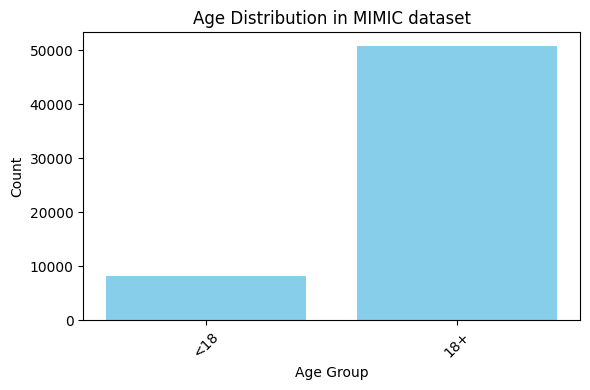

In [54]:
# Create a bar chart
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
plt.bar(age_cat_counts.index, age_cat_counts.values, color='skyblue')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Proportion of Age Group')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()

2. Age Distribution in MIMIC dataset

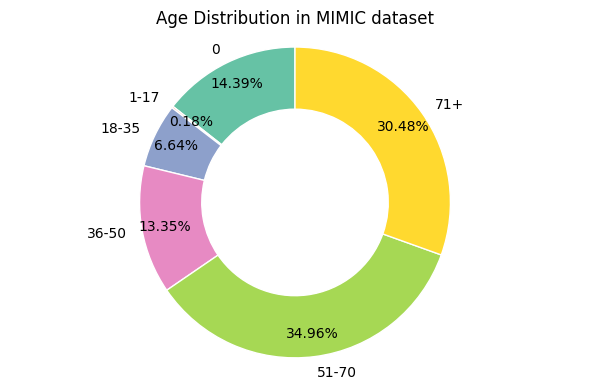

In [26]:
# Calculate the counts for each age group
age_group_counts = df_demographic_full['AGE_cat'].value_counts()

# Sort the age groups based on their labels
age_group_counts = age_group_counts.sort_index()

# Create a donut chart
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
colors = sns.color_palette("Set2")
plt.pie(age_group_counts.values, labels=age_group_counts.index, colors=colors, autopct='%1.2f%%', startangle=90,
        pctdistance=0.85, wedgeprops=dict(width=0.4, edgecolor='w'))

# Draw a white circle in the center to create the donut effect
centre_circle = plt.Circle((0,0),0.60,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Add a title
plt.title('Age Distribution in MIMIC dataset')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

plt.tight_layout()
plt.show()

3. Age Distribution by Gender

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


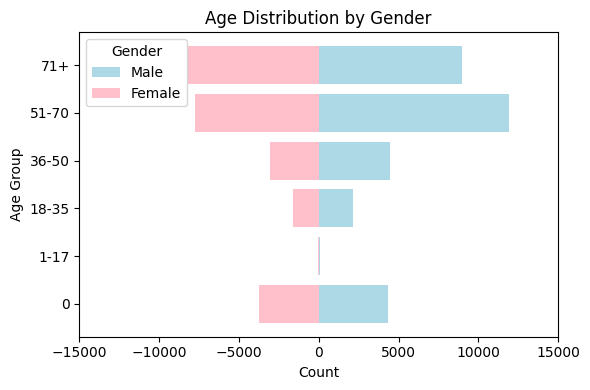

In [28]:
# Sort the DataFrame by 'AgeGroup' column
df_demographic_full.sort_values(by='AGE_cat', inplace=True)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# Count the number of observations for each AgeGroup and GENDER
age_gender_counts = df_demographic_full.groupby(['AGE_cat', 'GENDER']).size().unstack().reset_index()

# Create side-by-side bars for males and females with opposite directions
ax.barh(age_gender_counts['AGE_cat'], age_gender_counts['M'], color="lightblue", label='Male')
ax.barh(age_gender_counts['AGE_cat'], -age_gender_counts['F'], color="pink", label='Female')

# Set labels, title, and legend
ax.set_xlabel('Count')
ax.set_ylabel('Age Group')
ax.set_title('Age Distribution by Gender')
ax.legend(title='Gender')

# Set symmetric x-axis limits
ax.set_xlim(-15000, 15000)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

4. Distribution of Age by Non-Sepsis and Sepsis 

In [ ]:
# create age category 
df_demographic_full = util.categorise_age(df_demographic_full)
# plotting the age of admissions
df_demographic_full.boxplot(column=['AGE'], by='IS_SEPSIS')

### 1.2.3 Gender

1. Proportion of Gender

In [ ]:
# Plotting the counts in a donut chart
gender_fig_donut, gender_ax_donut = plt.subplots()
gender_colors = ["pink",'lightblue']
gender_ax_donut.pie(gender_counts, labels=gender_long_labels.unique(), colors=gender_colors,
             autopct='%1.2f%%', startangle=90, pctdistance=0.85, wedgeprops=dict(width=0.4, edgecolor='w'))
gender_ax_donut.set_title("Proportions of Gender")
centre_circle = plt.Circle((0,0),0.60,fc='white')
gender_fig_donut.gca().add_artist(centre_circle)
plt.show()

### 1.2.4 Discharge Location

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


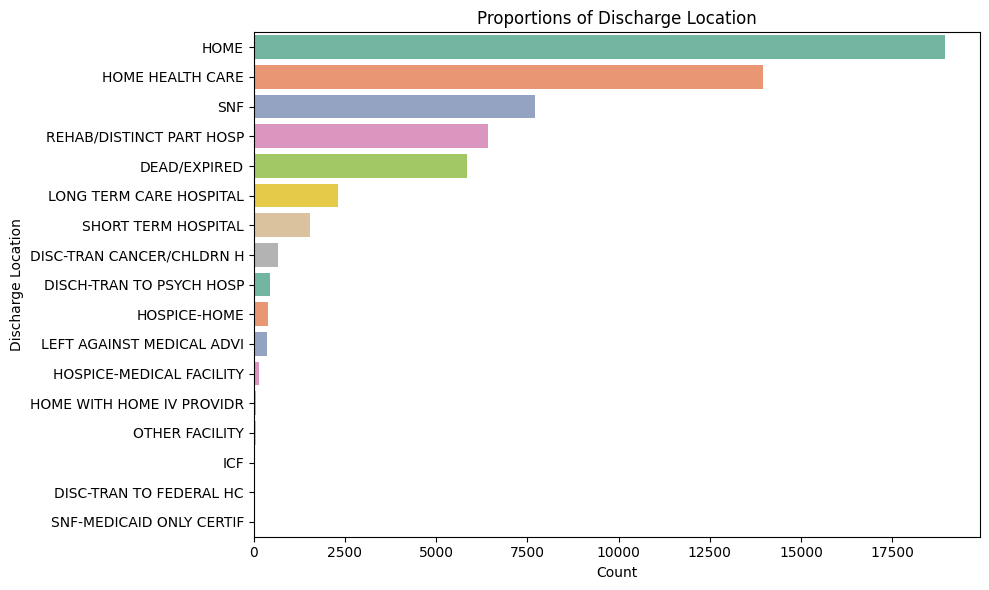

In [29]:
# Count the number of instances for each discharge location
discharge_location_counts = df_demographic_full["DISCHARGE_LOCATION"].value_counts()

# Create a figure and axis for the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for the chart
colors = sns.color_palette("Set2")

# Create a bar chart for discharge locations
sns.barplot(x=discharge_location_counts.values, y=discharge_location_counts.index, palette=colors, ax=ax)

# Set labels and title
ax.set_xlabel('Count')
ax.set_ylabel('Discharge Location')
ax.set_title('Proportions of Discharge Location')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### 1.2.5 Mortality Rate

1. Proportions of Sepsis Admission

In [ ]:
# Plotting the counts in a donut chart
fig_donut, ax_donut = plt.subplots()

long_labels = df_demographic_full['IS_SEPSIS'].map(label_dict)
colors = sns.color_palette("Set2")
ax_donut.pie(label_counts, labels=long_labels.unique(), colors=colors,
             autopct='%1.2f%%', startangle=90, pctdistance=0.85, wedgeprops=dict(width=0.4, edgecolor='w'))
ax_donut.set_title("Proportions of Sepsis Admission")
centre_circle = plt.Circle((0,0),0.60,fc='white')
fig_donut.gca().add_artist(centre_circle)
plt.show()

2. Distribution of EXPIRE_FLAG in IS_SEPSIS Classes

In [ ]:
# Create a 100% stacked bar chart
fig, ax = plt.subplots(figsize=(6, 4))
mortality_crosstab_percentage.plot(kind="bar", stacked=True, ax=ax)

# Set labels and title
ax.set_xticklabels(['Non-Sepsis', 'Sepsis'], rotation=0)
ax.set_ylabel('Percentage (%)')
ax.set_title('Distribution of EXPIRE_FLAG in IS_SEPSIS Classes')

# Add a legend
ax.legend(title='EXPIRE_FLAG', labels=['Survived', 'Died'], loc='upper right')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

3. Death Rate of Sepsis Patients

In [ ]:
# Filter the DataFrame for sepsis patients (IS_SEPSIS=1) who have died (EXPIRE_FLAG=1)
sepsis_expire_counts = df_demographic_full[(df_demographic_full['IS_SEPSIS'] == 1) & (df_demographic_full['EXPIRE_FLAG'] == 1)]

# Count the number of instances
death_count = len(sepsis_expire_counts)

# Count the number of sepsis patients
sepsis_patient_count = len(df_demographic_full[df_demographic_full['IS_SEPSIS'] == 1])

# Calculate the survival rate
survival_rate = (sepsis_patient_count - death_count) / sepsis_patient_count
death_rate = 1 - survival_rate

# Create a figure and axis for the donut chart
fig_donut, ax_donut = plt.subplots()

# Define labels and colors for the chart
labels = ['Survived', 'Died']
colors = ['lightblue', 'darkgrey']

# Plot the counts in a donut chart
ax_donut.pie([survival_rate, death_rate], labels=labels, colors=colors,
              autopct='%1.2f%%', startangle=90, pctdistance=0.85, wedgeprops=dict(width=0.4, edgecolor='w'))
ax_donut.set_title("Death Rate of Sepsis Patients")

# Create a white circle in the center to make it a donut chart
centre_circle = plt.Circle((0, 0), 0.60, fc='white')
fig_donut.gca().add_artist(centre_circle)

# Adjust layout and show the plot
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.tight_layout()
plt.show()

### 1.2.6 Admission Length of Stay

Histograms of Length of Stay for Sepsis and Non-Sepsis Patients

In [ ]:
# Histogram
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(stay_sepsis, bins=30, color='blue', alpha=0.7, label='Sepsis')
plt.title('Histogram of Length of Stay for Sepsis')
plt.xlabel('Days')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(stay_non_sepsis, bins=30, color='red', alpha=0.7, label='Non-Sepsis')
plt.title('Histogram of Length of Stay for Non-Sepsis')
plt.xlabel('Days')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Q-Q plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
stats.probplot(stay_sepsis, plot=plt)
plt.title('Q-Q Plot for Sepsis')

plt.subplot(1, 2, 2)
stats.probplot(stay_non_sepsis, plot=plt)
plt.title('Q-Q Plot for Non-Sepsis')

plt.tight_layout()
plt.show()

 ### 1.2.7 Time for First Blood Test 

Histtogram and Q-Q Plot of First Blood Test since admissions for Sepsis and Non-Sepsis patients

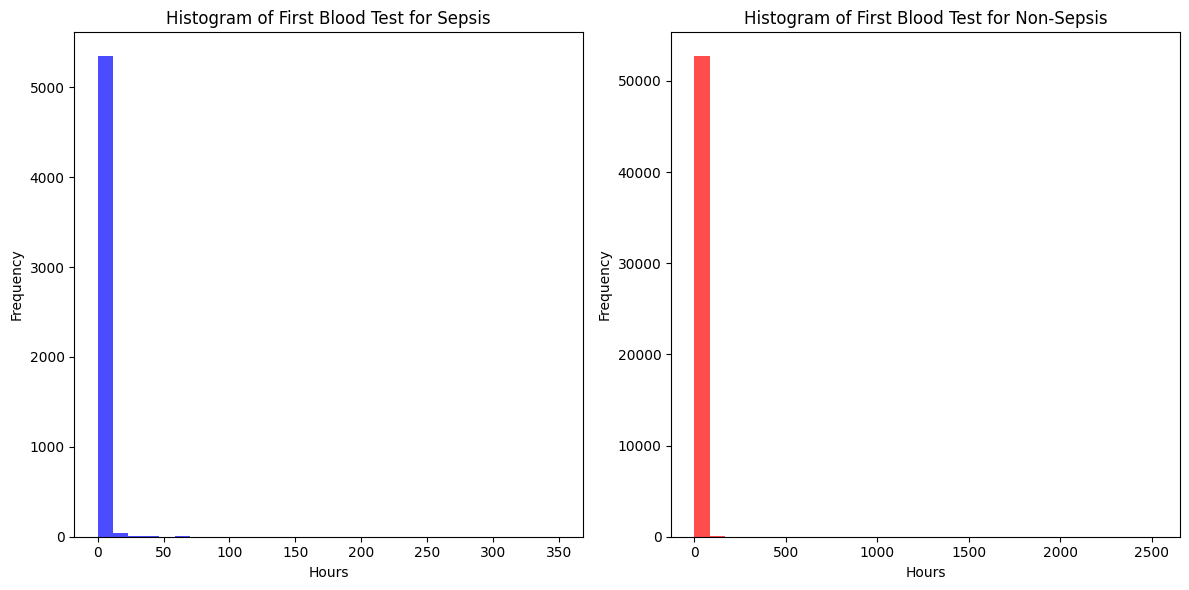

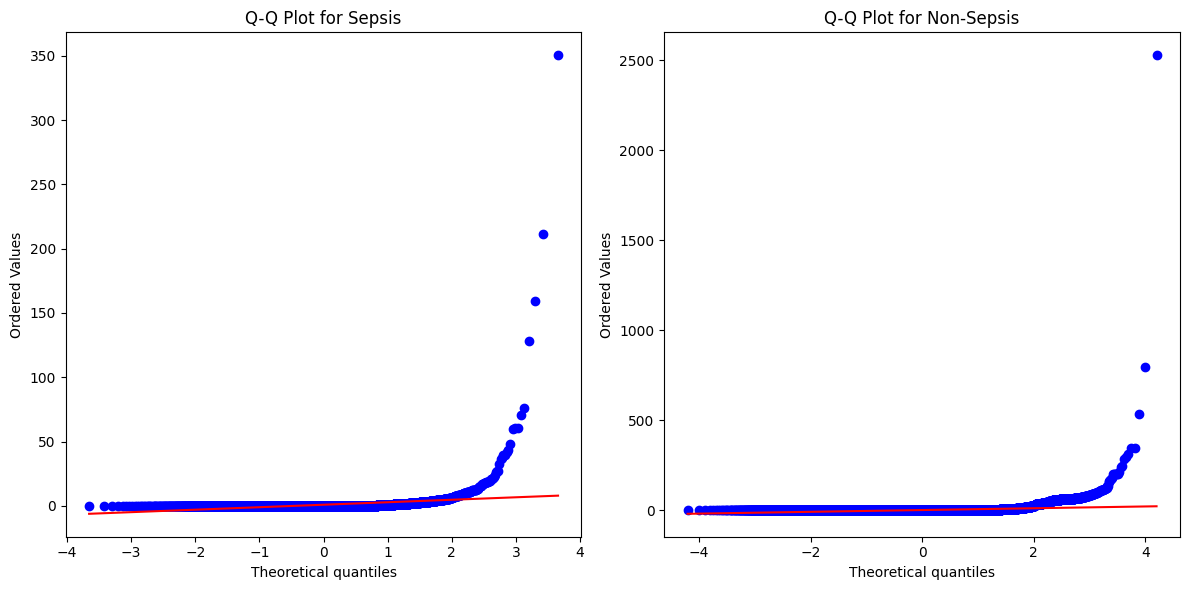

In [213]:
# Histogram
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(first_blood_sepsis, bins=30, color='blue', alpha=0.7, label='Sepsis')
plt.title('Histogram of First Blood Test for Sepsis')
plt.xlabel('Hours')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(first_blood_non_sepsis , bins=30, color='red', alpha=0.7, label='Non-Sepsis')
plt.title('Histogram of First Blood Test for Non-Sepsis')
plt.xlabel('Hours')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Q-Q plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
stats.probplot(first_blood_sepsis , plot=plt)
plt.title('Q-Q Plot for Sepsis')

plt.subplot(1, 2, 2)
stats.probplot(first_blood_non_sepsis , plot=plt)
plt.title('Q-Q Plot for Non-Sepsis')

plt.tight_layout()
plt.show()

### 1.2.8 Labevents

Estimating labevents time interval

In [30]:
# Compute STAY_DURATION as CHARTTIME - ADMITTIME
combined_df['STAY_DURATION'] = (combined_df['CHARTTIME'] - combined_df['ADMITTIME']).dt.total_seconds() / 3600  # duration in hours

# Compute BEFORE_DISCHARGE as DISCHTIME - CHARTTIME
combined_df['BEFORE_DISCHARGE'] = (combined_df['CHARTTIME'] - combined_df['DISCHTIME']).dt.total_seconds() / 3600  # duration in hours

In [31]:
# First, sort the dataframe by HADM_ID and CHARTTIME
combined_df = combined_df.sort_values(by=['SUBJECT_ID', 'HADM_ID', 'CHARTTIME'])

# Generate a unique TEST_NO for each CHARTTIME within HADM_ID
combined_df['TEST_NO'] = combined_df.groupby(['HADM_ID', 'CHARTTIME']).ngroup() + 1

# To get the test number only considering HADM_ID:
combined_df['TEST_NO'] = combined_df.groupby('HADM_ID')['CHARTTIME'].transform(lambda x: x.rank(method='dense')).astype(int)

1. Distribution of all HADM_IDs with Labevents Before Admission

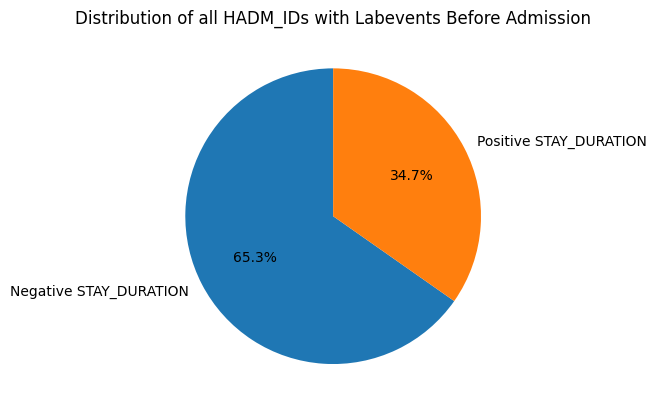

In [32]:
# Filter for rows where TEST_NO == 1
test_no_1_df = combined_df[combined_df['TEST_NO'] == 1]

# Count unique HADM_IDs for negative and positive STAY_DURATION
negative_hadm_count = test_no_1_df[test_no_1_df['STAY_DURATION'] < 0]['HADM_ID'].nunique()
positive_hadm_count = test_no_1_df[test_no_1_df['STAY_DURATION'] >= 0]['HADM_ID'].nunique()

# Data to plot
labels = ['Negative STAY_DURATION', 'Positive STAY_DURATION']
sizes = [negative_hadm_count, positive_hadm_count]

# Plot pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of all HADM_IDs with Labevents Before Admission")
plt.show()

In [33]:
# Create a mapping of HADM_ID to CHARTTIME when TEST_NO is 1
charttime_mapping = combined_df[combined_df['TEST_NO'] == 1].set_index('HADM_ID')['CHARTTIME'].to_dict()

# For rows where STAY_DURATION < 0, replace ADMITTIME with the corresponding CHARTTIME from the mapping
mask = combined_df['STAY_DURATION'] < 0
combined_df.loc[mask, 't0'] = combined_df.loc[mask, 'HADM_ID'].map(charttime_mapping)

# For other rows, set 't0' as 'ADMITTIME'
combined_df['t0'] = combined_df['t0'].fillna(combined_df['ADMITTIME'])

# Add another column "UPDATED_STAY" with the updated t0
combined_df['UPDATED_STAY'] = (combined_df['CHARTTIME'] - combined_df['t0']).dt.total_seconds() / 3600  # duration in hours

# Compute TOTAL_STAY as DISCHTIME - t0
combined_df['TOTAL_STAY'] = (combined_df['DISCHTIME'] - combined_df['t0']).dt.total_seconds() / 3600  # duration in hours

In [34]:
# Round up to 1
combined_df['STAY_DURATION'] = np.ceil(combined_df['STAY_DURATION'])
combined_df['BEFORE_DISCHARGE'] = np.ceil(combined_df['BEFORE_DISCHARGE'])
combined_df['TOTAL_STAY'] = np.ceil(combined_df['TOTAL_STAY'])
combined_df['UPDATED_STAY'] = np.ceil(combined_df['UPDATED_STAY'])

In [35]:
selected_columns = ['STAY_DURATION', 'BEFORE_DISCHARGE', 'TOTAL_STAY', 'UPDATED_STAY']
pd.set_option('display.float_format', '{:.2f}'.format)
combined_df[selected_columns].describe()

,STAY_DURATION,BEFORE_DISCHARGE,TOTAL_STAY,UPDATED_STAY
count,22264050.00,22264050.00,22264050.00,22264050.00
mean,204.63,-318.05,523.48,204.94
std,327.39,400.97,565.69,327.20
min,-59.00,-7068.00,-22.00,0.00
25%,23.00,-390.00,184.00,23.00
50%,96.00,-191.00,346.00,96.00
75%,252.00,-96.00,656.00,252.00
max,7064.00,1245.00,7072.00,7064.00


In [37]:
# Calculate the number of labevents per hour
labevent_counts = combined_df.groupby('UPDATED_STAY').size().reset_index(name='counts')

# Extract columns and drop duplicates
unique_hadm_df = combined_df[['HADM_ID', 'TOTAL_STAY']].drop_duplicates()

# List to store results
results = []

# Iterate over each UPDATED_STAY
for updated_stay in combined_df['UPDATED_STAY'].unique():
    count = unique_hadm_df[unique_hadm_df['TOTAL_STAY'] > updated_stay]['HADM_ID'].nunique()
    results.append((updated_stay, count))

# Convert results to dataframe
result_df = pd.DataFrame(results, columns=['UPDATED_STAY', 'unique_hadm_count'])

In [38]:
merged_data = labevent_counts.merge(result_df, on='UPDATED_STAY')
merged_data['avg'] = merged_data['counts'] / merged_data['unique_hadm_count']
merged_data

,UPDATED_STAY,counts,unique_hadm_count,avg
0,0.00,1130268,58129,19.44
1,1.00,577510,58113,9.94
2,2.00,407997,58070,7.03
3,3.00,342910,58002,5.91
4,4.00,289722,57963,5.00
...,...,...,...,...
4261,7013.00,25,1,25.00
4262,7019.00,9,1,9.00
4263,7037.00,31,1,31.00
4264,7060.00,20,1,20.00


2. Average No. of Labevents per UPDATED_STAY (all admissions)

In [ ]:
# Plotting the line chart
sns.lineplot(x='UPDATED_STAY', y='avg', data=merged_data)

plt.title('Average No. of Labevents per UPDATED_STAY (all admissions)')
plt.xlabel('UPDATED_STAY (hours)')
plt.ylabel('Average No. of Labevents')
plt.xlim((0, 24))
plt.ylim((0, 20))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

3. Number of Events vs. Stay Duration for HADM_ID 111970

/Users/amyhung/Documents/CITS5553_project/data-science-capstone-project/.venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/amyhung/Documents/CITS5553_project/data-science-capstone-project/.venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/amyhung/Documents/CITS5553_project/data-science-capstone-project/.venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/amyhung/Documents/CITS5553_project/d

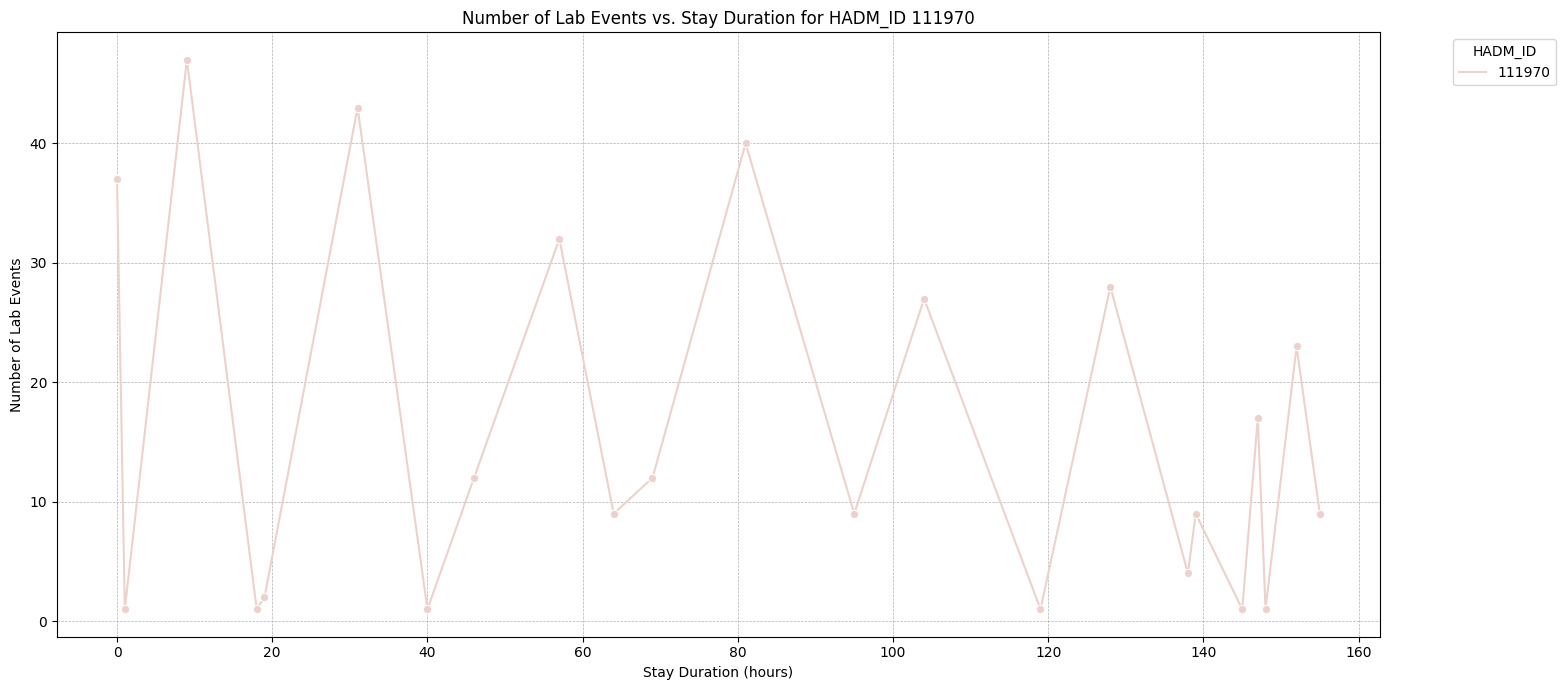

In [40]:
# Filter dataset for a specific HADM_ID
subject_data = combined_df[combined_df['HADM_ID'] == 111970]
grouped_subject_data = subject_data.groupby(['HADM_ID', 'UPDATED_STAY']).size().reset_index(name='counts')

# Plot
plt.figure(figsize=(14, 7))
sns.lineplot(x='UPDATED_STAY', y='counts', hue='HADM_ID', data=grouped_subject_data, marker='o')

plt.title('Number of Lab Events vs. Stay Duration for HADM_ID 111970')
plt.xlabel('Stay Duration (hours)')
plt.ylabel('Number of Lab Events')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.legend(title='HADM_ID', bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
plt.show()

4. Distribution of Sepsis HADM_IDs with Labevents Before Admission

In [41]:
# For sepsis admission only
sepsis_df = combined_df[combined_df["IS_SEPSIS"]== 1]

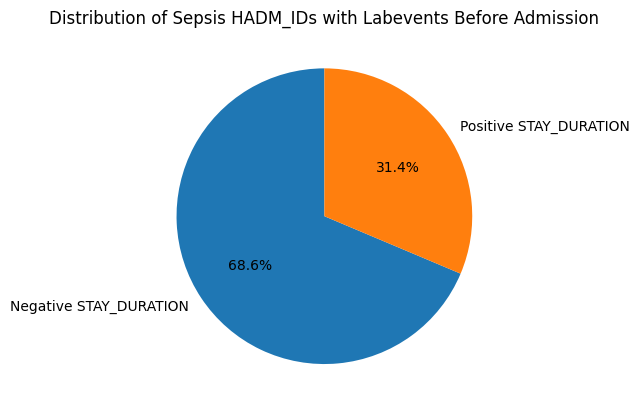

In [42]:
# Filter for rows where TEST_NO == 1
test_no_1_sepsis_df = sepsis_df[sepsis_df['TEST_NO'] == 1]

# Count unique HADM_IDs for negative and positive STAY_DURATION
negative_hadm_sepsis_count = test_no_1_sepsis_df[test_no_1_sepsis_df['STAY_DURATION'] < 0]['HADM_ID'].nunique()
positive_hadm_sepsis_count = test_no_1_sepsis_df[test_no_1_sepsis_df['STAY_DURATION'] >= 0]['HADM_ID'].nunique()

# Data to plot
labels = ['Negative STAY_DURATION', 'Positive STAY_DURATION']
sizes = [negative_hadm_sepsis_count, positive_hadm_sepsis_count]

# Plot pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Sepsis HADM_IDs with Labevents Before Admission")
plt.show()

In [43]:
# Calculate the number of labevents per hour
labevent_sepsis_counts = sepsis_df.groupby('UPDATED_STAY').size().reset_index(name='counts')

# Extract columns and drop duplicates
unique_sepsis_hadm_df = sepsis_df[['HADM_ID', 'TOTAL_STAY']].drop_duplicates()

# List to store results
results_sepsis = []

# Iterate over each UPDATED_STAY
for updated_stay in sepsis_df['UPDATED_STAY'].unique():
    count = unique_sepsis_hadm_df[unique_sepsis_hadm_df['TOTAL_STAY'] > updated_stay]['HADM_ID'].nunique()
    results_sepsis.append((updated_stay, count))

# Convert results to dataframe
result_sepsis_df = pd.DataFrame(results_sepsis, columns=['UPDATED_STAY', 'unique_hadm_count'])

merged_sepsis_data = labevent_sepsis_counts.merge(result_sepsis_df, on='UPDATED_STAY')
merged_sepsis_data['avg'] = merged_sepsis_data['counts'] / merged_sepsis_data['unique_hadm_count']
merged_sepsis_data

,UPDATED_STAY,counts,unique_hadm_count,avg
0,0.00,142109,5398,26.33
1,1.00,78053,5396,14.46
2,2.00,51227,5392,9.50
3,3.00,44481,5385,8.26
4,4.00,36694,5383,6.82
...,...,...,...,...
4077,7013.00,25,1,25.00
4078,7019.00,9,1,9.00
4079,7037.00,31,1,31.00
4080,7060.00,20,1,20.00


5. Average No. of Labevents per UPDATED_STAY (sepsis admissions)

/Users/amyhung/Documents/CITS5553_project/data-science-capstone-project/.venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/amyhung/Documents/CITS5553_project/data-science-capstone-project/.venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/amyhung/Documents/CITS5553_project/data-science-capstone-project/.venv/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/amyhung/Documents/CITS5553

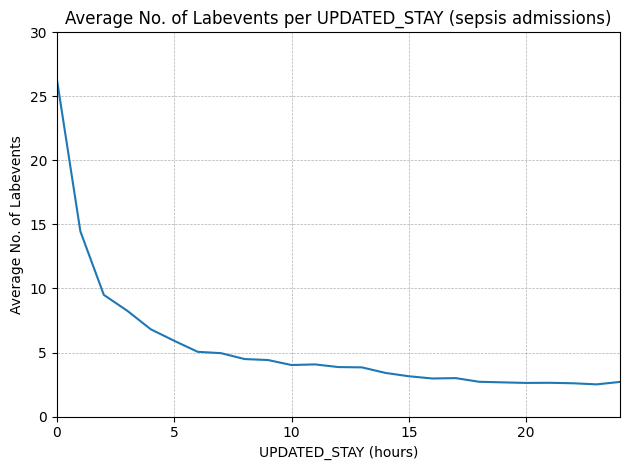

In [44]:
# Plotting the line chart
sns.lineplot(x='UPDATED_STAY', y='avg', data=merged_sepsis_data)

plt.title('Average No. of Labevents per UPDATED_STAY (sepsis admissions)')
plt.xlabel('UPDATED_STAY (hours)')
plt.ylabel('Average No. of Labevents')
plt.xlim((0, 24))
plt.ylim((0, 30))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

### 1.2.9 Microbiology Events

1. Top 15 Common Bacteria Affecting Sepsis Patients

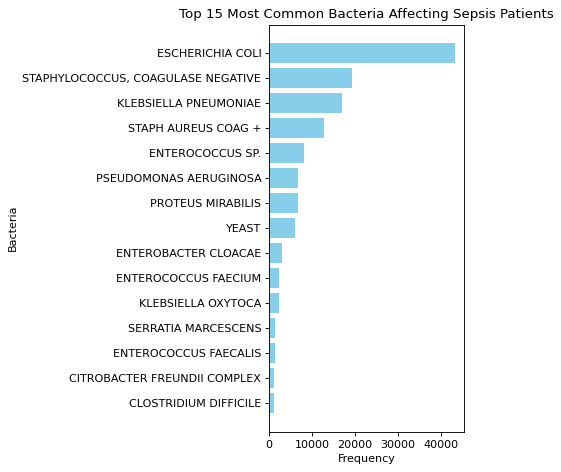

In [41]:
# Sample data (replace with your actual data)
sepsis_data = df_demographic_full

microbiology_data = dataLoader.load_microbiologyevents()
microbiology_data
# Filter the microbiology data to include only rows with sepsis patients
sepsis_hadm_ids = sepsis_data['HADM_ID'].tolist()
valid_spec_types = ['URINE', 'BLOOD CULTURE', 'STOOL']

filtered_microbiology_data = microbiology_data[microbiology_data['HADM_ID'].isin(sepsis_hadm_ids)]

filtered_microbiology_data = filtered_microbiology_data[filtered_microbiology_data['SPEC_TYPE_DESC'].isin(valid_spec_types)]
# Group the filtered microbiology data by bacteria and count occurrences
bacteria_counts = filtered_microbiology_data['ORG_NAME'].value_counts()

# Sort the bacteria by frequency in descending order
bacteria_counts = bacteria_counts.sort_values(ascending=False)
top_15_bacteria_counts = bacteria_counts.head(15)
# Create a bar chart to show the most common bacteria affecting sepsis patients
plt.figure(figsize=(6, 6))  # Adjust the figure size as needed
top_15_bacteria_counts = top_15_bacteria_counts.iloc[::-1]
plt.barh(top_15_bacteria_counts.index, top_15_bacteria_counts.values, color='skyblue')
plt.title('Top 15 Most Common Bacteria Affecting Sepsis Patients')
plt.xlabel('Frequency')
plt.ylabel('Bacteria')
plt.rcParams['figure.dpi'] = 10 
# Show the bar chart
plt.tight_layout()
plt.show()
# In this updated code, we've changed the plt.bar to plt.barh to create a horizontal bar chart, which effectively rotates the plot 90 degrees to the right. We've also adjusted the figure size to ensure the plot looks appropriate in the landscape orientation.

# Show the bar chart
plt.show()

2. Proportion of Pass and Fail Theory

In [19]:
#CHECKING the importance of Microbiology events

# Sample data (replace with your actual data)
sepsis_data = df_demographic_full

df_micro = pd.DataFrame(dataLoader.load_microbiologyevents())

# Convert CHARTTIME column to datetime
df_micro['CHARTTIME'] = pd.to_datetime(df_micro['CHARTTIME'], errors='coerce', format='%d/%m/%Y %H:%M')


# Merge the two dataframes based on HADM_ID
df_micro_demo = pd.merge(df_micro, sepsis_data, on='HADM_ID')


selected_columns = ['HADM_ID', 'CHARTTIME', 'IS_SEPSIS', 'ORG_NAME']
filtered_df = df_micro_demo[selected_columns]
filtered_df

merged_df_sorted = filtered_df.sort_values(by='HADM_ID')


# Define conditions for filtering the DataFrame
condition1 = (merged_df_sorted['IS_SEPSIS'] == 1) & (~merged_df_sorted['ORG_NAME'].isnull())
condition2 = (merged_df_sorted['IS_SEPSIS'] == 0) & (merged_df_sorted['ORG_NAME'].isnull())


merged_df_sorted['Flag'] = np.where(condition1 | condition2, 'Pass', 'Fail')


#merged_df_sorted.to_excel('filtered_and_flagged_data.xlsx', index=False)

In [20]:
# Separate data into 'Pass' and 'Fail' DataFrames
pass_df = merged_df_sorted[merged_df_sorted['Flag'] == 'Pass']
fail_df = merged_df_sorted[merged_df_sorted['Flag'] == 'Fail']

# Get unique rows for each HADM_ID in 'Pass' DataFrame
unique_pass_df = pass_df.drop_duplicates(subset='HADM_ID')

# Get unique rows for each HADM_ID in 'Fail' DataFrame
unique_fail_df = fail_df.drop_duplicates(subset='HADM_ID')

# Export 'Pass' and 'Fail' DataFrames to Excel files
pass_df.to_excel('pass_data.xlsx', index=False)
fail_df.to_excel('fail_data.xlsx', index=False)

# Export unique rows for 'Pass' and 'Fail' HADM_ID to Excel files
#unique_pass_df.to_excel('unique_pass_data.xlsx', index=False)
#unique_fail_df.to_excel('unique_fail_data.xlsx', index=False)

In [21]:
# Concatenate unique_pass_df and unique_fail_df without overlapping HADM_ID

filtered_fail_df = unique_fail_df[~unique_fail_df['HADM_ID'].isin(unique_pass_df['HADM_ID'])]

# Concatenate pass_df and filtered_fail_df into whole_df
whole_df = pd.concat([unique_pass_df, filtered_fail_df], ignore_index=True)

# Export the concatenated DataFrame to an Excel file
#whole_df.to_excel('whole_data_pass_and_fail.xlsx', index=False)

Proportion of Flag = Pass: 0.95
Proportion of Flag = Fail: 0.05


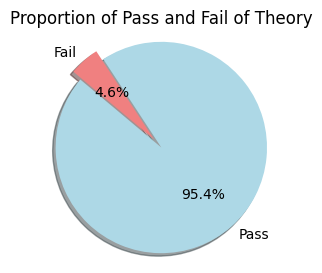

In [22]:
# Count the occurrences of 'Pass' and 'Fail' in the 'Flag' column
flag_counts = whole_df['Flag'].value_counts()

# Calculate proportions
pass_proportion = flag_counts.get('Pass', 0) / len(whole_df)
fail_proportion = flag_counts.get('Fail', 0) / len(whole_df)

# Print proportions
print(f'Proportion of Flag = Pass: {pass_proportion:.2f}')
print(f'Proportion of Flag = Fail: {fail_proportion:.2f}')

labels = ['Pass', 'Fail']
sizes = [pass_proportion, fail_proportion]  # Replace with your actual proportions
colors = ['lightblue', 'lightcoral']
explode = (0.1, 0)  # Explode the "Pass" slice (optional)


plt.figure(figsize=(3, 3))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

plt.title('Proof that Microbiology Events is of little importance')

plt.show()

#06/10/2023 end

According to the above Pass and Fail Theory, the microbiology events is not useful for predicting sepsis. 

### 1.2.10 EDA of datasets by using Sweetviz library


1. Labevents dataset

In [ ]:
labevents_report=sv.analyze(df_labevents_full.iloc[:100000])
labevents_report.show_html('Labevents.html')

2. Diagnoses dataset

In [ ]:
diagnoses_report=sv.analyze(df_diagnoses_icd_full)
diagnoses_report.show_html('Diagnoses_icd.html')

3. Microbiology events dataset

In [ ]:
microbioevents_report=sv.analyze(df_microbiologyevents_full)
microbioevents_report.show_html('Microbiologyevents.html')

4. Patients dataset

In [ ]:
patients_report=sv.analyze(df_patients_full)
patients_report.show_html('Patients.html')

5. Admissions dataset

In [ ]:
admissions_report=sv.analyze(df_admissions_full)
admissions_report.show_html('Admissions.html')

6. Demographic dataset

In [ ]:
demographic_report=sv.analyze(df_demographic_full)
demographic_report.show_html('Demographic.html')